In [27]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pip install opendatasets
! pip install datasets

In [ ]:
import opendatasets as od

In [ ]:
! pip install lightning dataclasses accelerate diffusers p_tqdm

In [ ]:
od.download(
	"https://www.kaggle.com/datasets/mahmoudnoor/high-resolution-catdogbird-image-dataset-13000")


od.download(
	"https://www.kaggle.com/datasets/joaopauloschuler/cifar10-64x64-resized-via-cai-super-resolution")

In [1]:
import os
import torch
from torch import nn
from tqdm import tqdm
from PIL import Image
from p_tqdm import p_map
import lightning.pytorch as pl
import torch.nn.functional as F
from dataclasses import dataclass
from accelerate import Accelerator
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, random_split
from lightning.pytorch.loggers import TensorBoardLogger
from diffusers.optimization import get_cosine_schedule_with_warmup
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import random
from lightning.pytorch.loggers import WandbLogger
wandb_logger = WandbLogger(project="Diffusion-cat-dog-bird", log_model=True, name='128-pretrained-unet')

import torchvision.transforms as T
transform = T.ToPILImage()

In [8]:
@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 64
    eval_batch_size = train_batch_size  # how many images to sample during evaluation
    num_epochs = 100
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    num_workers = 12
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'cat-dogs-birds'  # the model namy locally and on the HF Hub
    accelerator = Accelerator(mixed_precision=mixed_precision, gradient_accumulation_steps=gradient_accumulation_steps)

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [9]:
train_transform = transforms.Compose(
            [
                transforms.Resize((config.image_size, config.image_size)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

test_transform = transforms.Compose(
            [
                transforms.Resize((config.image_size, config.image_size)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

train_dataset = datasets.ImageFolder(root='high-resolution-catdogbird-image-dataset-13000', transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True, num_workers=config.num_workers)

In [17]:
class DiffusionModel(pl.LightningModule):

    def __init__(self, config):
        super().__init__()
        self.config = config

        self.last_image = ""
        self.label_projection = nn.Embedding(3, 768)

        # Initialize UNet model
        #self.unet = UNet_conditional(c_in=4, c_out=4, time_dim=256, num_classes=3, remove_deep_conv=False)
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", 
                                                          #revision="fp16", torch_dtype=torch.float16,
                                                          subfolder="unet")

        # self.unet = UNet2DConditionModel(
        #             sample_size=16,  # the target image resolution
        #             in_channels=4,  # the number of input channels, 3 for RGB images
        #             out_channels=4,  # the number of output channels
        #             layers_per_block=2,  # how many ResNet layers to use per UNet block
        #             block_out_channels=(256, 256, 256, 512),  # the number of output channels for each UNet block , 256, 256, 512, 512
        #             time_embedding_dim=256,
        #             encoder_hid_dim=256,
        #             transformer_layers_per_block=2,
        #             down_block_types=(
        #                 "CrossAttnDownBlock2D",  # a regular ResNet downsampling block
        #                 "CrossAttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        #                 "CrossAttnDownBlock2D",
        #                 "DownBlock2D",
        #             ),
        #             up_block_types=(
        #                 "UpBlock2D",  # a regular ResNet upsampling block
        #                 "CrossAttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        #                 "CrossAttnUpBlock2D",
        #                 "CrossAttnUpBlock2D"
        #             ),
        #             mid_block_type=(
        #                 "UNetMidBlock2DCrossAttn"
        #             )
        #         )

        # Initialize VAE
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                                  revision="fp16", torch_dtype=torch.float16,
                                                  subfolder="vae")

        # Initialize noise scheduler
        self.noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

    def forward(self, x, timesteps, hidden_embed):
        # Forward pass through UNet
        #noise_pred = self.unet(x, timesteps, hidden_embed)
        noise_pred = self.unet(x, timesteps, encoder_hidden_states=hidden_embed.unsqueeze(1))["sample"]
        return noise_pred

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.unet.parameters(), lr=self.config.learning_rate)
        scheduler = OneCycleLR(
                        optimizer,
                        max_lr=self.config.learning_rate,
                        pct_start=6/self.trainer.max_epochs,
                        epochs=self.trainer.max_epochs,
                        steps_per_epoch=len(train_loader),
                        anneal_strategy='cos',
                        div_factor=100, #data_module.dataset.num_rows
                        final_div_factor=10,
                        #three_phase=True
                )
        return {'optimizer': optimizer,
                'lr_scheduler': {'scheduler': scheduler, 'interval': 'step'}}
        #return(optimizer)

    def process_batch(self, batch):

        clean_images, targets = batch

        # Encode the clean images to obtain latent representations
        with torch.no_grad():
            clean_latent = self.vae.encode(clean_images.to(torch.float16)).latent_dist.sample()
            clean_latent = ((clean_latent * 2) - 1) * 0.18215

        # Sample noise to add to the images
        noise = torch.randn(clean_latent.shape, device=self.device)

        # Sample a random timestep for each image
        bs = clean_images.size(0)
        timesteps = torch.randint(0, self.noise_scheduler.num_train_timesteps, (bs,), device=self.device).long()

        # Add noise to the clean latent representations (forward diffusion)
        noisy_images = self.noise_scheduler.add_noise(clean_latent, noise, timesteps)

        # Label Projection
        target_embed = self.label_projection(targets)

        # Predict the noise residual
        noise_pred = self(noisy_images, timesteps, target_embed)  # Calls the forward method

        # Compute the loss
        loss = F.mse_loss(noise_pred, noise)

        self.last_image = (clean_images[-1], targets[-1])

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.process_batch(batch)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    # def validation_step(self, batch, batch_idx):
    #     val_loss = self.process_batch(batch)
    #     self.log('val_loss', val_loss, on_epoch=True, prog_bar=True, logger=True)
    #     return val_loss
    
    def latents_to_pil(self, latents):
        # batch of latents -> list of images
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = self.vae.decode(latents.to(torch.float16)).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images][0]
        return pil_images

    def generate_and_save_images(self, current_epoch):
        generator = torch.manual_seed(42)
        noise = torch.randn(1, 4, 16, 16, generator=generator).cuda()
        label = self.label_projection(torch.tensor(random.randint(0, 2)).cuda())
        noise = noise * self.noise_scheduler.init_noise_sigma

        for i, t in tqdm(enumerate(self.noise_scheduler.timesteps), total=len(self.noise_scheduler.timesteps)):
            noise = self.noise_scheduler.scale_model_input(noise, t)

            with torch.no_grad():
                #noise_pred = self.unet(noise, torch.tensor(t).to(noise.device), torch.tensor([random.randint(0, 2)]).to(noise.device))
                noise_pred = self.unet(noise, t, encoder_hidden_states=label.unsqueeze(0).unsqueeze(0))["sample"]

            noise = self.noise_scheduler.step(noise_pred, t.long(), noise).prev_sample

        decoded_noise = self.latents_to_pil(noise)

        # with torch.no_grad():
        #     decoded_noise = diffusion_model.vae.decode(noise.to(torch.float16)).sample

        #decoded_noise = transform(decoded_noise[0])

        #decoded_noise = pil_images[0]
        
        # Save the generated images to a unique folder for the current epoch
        save_dir = f"generated_images/epoch_{current_epoch}"
        os.makedirs(save_dir, exist_ok=True)
        
        decoded_noise.save(os.path.join(save_dir, f"image.png"))
        wandb_logger.log_image(key=f"generated_epoch_{current_epoch}", images=[decoded_noise])
        #self.logger.log_image(f"generated_epoch_{current_epoch}", [decoded_noise,]) 

    def apply_transform(self, image):
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return(pil_images)
    
    def generate_visualize(self, current_epoch):
        clean_images, targets = self.last_image
        clean_images = clean_images.unsqueeze(0)

        with torch.no_grad():
            clean_latent = self.vae.encode(clean_images.to(torch.float16)).latent_dist.sample()
            image = self.vae.decode(clean_latent.to(torch.float16)).sample
            
        save_dir = f"coded_images/epoch_{current_epoch}"
        save_dir_orig = f"original_images/epoch_{current_epoch}"

        clean_images = self.apply_transform(clean_images)[0]
        image = self.apply_transform(image)[0]

        os.makedirs(save_dir, exist_ok=True)
        os.makedirs(save_dir_orig, exist_ok=True)

        image.save(os.path.join(save_dir, f"image.png"))
        clean_images.save(os.path.join(save_dir_orig, f"image.png"))
            
    def on_train_epoch_end(self):
        self.generate_and_save_images(self.current_epoch)
        #self.generate_visualize(self.current_epoch)

diffusion_model = DiffusionModel(config)

In [18]:
trainer = pl.Trainer(
    precision='16-mixed' if config.mixed_precision=='fp16' else 32,  # Set precision
    accelerator='auto',
    devices='auto',
    strategy='auto',
    max_epochs=config.num_epochs,
    logger=[TensorBoardLogger("logs/", name="stable-diffusion"), wandb_logger],
    callbacks=[LearningRateMonitor(logging_interval="step"), ModelCheckpoint(monitor="train_loss_epoch", mode="min")],
    #limit_train_batches=0.3, 
    
)
torch.set_float32_matmul_precision('high')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(diffusion_model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params
----------------------------------------------------------
0 | label_projection | Embedding            | 2.3 K 
1 | unet             | UNet2DConditionModel | 859 M 
2 | vae              | AutoencoderKL        | 83.7 M
----------------------------------------------------------
943 M     Trainable params
0         Non-trainable params
943 M     Total params
3,772.709 Total estimated model params size (MB)


Epoch 0: 100%|██████████| 209/209 [01:44<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.355, train_loss_epoch=0.270]

100%|██████████| 1000/1000 [00:41<00:00, 24.26it/s]


Epoch 1:   0%|          | 0/209 [00:00<?, ?it/s, v_num=phgj, train_loss_step=0.355, train_loss_epoch=0.270]          

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1: 100%|██████████| 209/209 [01:43<00:00,  2.02it/s, v_num=phgj, train_loss_step=0.220, train_loss_epoch=0.246]

100%|██████████| 1000/1000 [00:40<00:00, 24.40it/s]


Epoch 2: 100%|██████████| 209/209 [01:43<00:00,  2.02it/s, v_num=phgj, train_loss_step=0.209, train_loss_epoch=0.238]

100%|██████████| 1000/1000 [00:41<00:00, 24.32it/s]


Epoch 3: 100%|██████████| 209/209 [01:43<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.194, train_loss_epoch=0.229]

100%|██████████| 1000/1000 [00:41<00:00, 24.35it/s]


Epoch 4: 100%|██████████| 209/209 [01:43<00:00,  2.02it/s, v_num=phgj, train_loss_step=0.179, train_loss_epoch=0.218]

100%|██████████| 1000/1000 [00:40<00:00, 24.39it/s]


Epoch 5: 100%|██████████| 209/209 [01:43<00:00,  2.02it/s, v_num=phgj, train_loss_step=0.164, train_loss_epoch=0.205]

100%|██████████| 1000/1000 [00:40<00:00, 24.43it/s]


Epoch 6: 100%|██████████| 209/209 [01:43<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.145, train_loss_epoch=0.187]

100%|██████████| 1000/1000 [00:41<00:00, 24.34it/s]


Epoch 7: 100%|██████████| 209/209 [01:43<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.126, train_loss_epoch=0.167]

100%|██████████| 1000/1000 [00:40<00:00, 24.44it/s]


Epoch 8: 100%|██████████| 209/209 [01:43<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.107, train_loss_epoch=0.147]

100%|██████████| 1000/1000 [00:41<00:00, 24.31it/s]


Epoch 9: 100%|██████████| 209/209 [01:43<00:00,  2.02it/s, v_num=phgj, train_loss_step=0.0924, train_loss_epoch=0.129]

100%|██████████| 1000/1000 [00:41<00:00, 24.38it/s]


Epoch 10: 100%|██████████| 209/209 [01:43<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.083, train_loss_epoch=0.114] 

100%|██████████| 1000/1000 [00:40<00:00, 24.39it/s]


Epoch 11: 100%|██████████| 209/209 [01:43<00:00,  2.01it/s, v_num=phgj, train_loss_step=0.0754, train_loss_epoch=0.100]

 52%|█████▏    | 518/1000 [00:21<00:19, 24.30it/s]
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
diffusion_model = DiffusionModel.load_from_checkpoint('logs/stable-diffusion/version_0/checkpoints/epoch=7-step=320.ckpt', config=config)

In [10]:
diffusion_model.device

device(type='cpu')

In [11]:
generator = torch.manual_seed(42)
noise = torch.randn(1, 4, 16, 16, generator=generator).cuda()
noise = noise * diffusion_model.noise_scheduler.init_noise_sigma
label = diffusion_model.label_projection(torch.tensor(2).cuda())


for i, t in tqdm(enumerate(diffusion_model.noise_scheduler.timesteps), total=len(diffusion_model.noise_scheduler.timesteps)):
    noise = diffusion_model.noise_scheduler.scale_model_input(noise, t)

    with torch.no_grad():
        noise_pred = diffusion_model.unet(noise, t, encoder_hidden_states=label.unsqueeze(0).unsqueeze(0))["sample"]

    noise = diffusion_model.noise_scheduler.step(noise_pred, t.long(), noise).prev_sample

AttributeError: 'Embedding' object has no attribute 'noise_scheduler'

In [ ]:
# from matplotlib import pyplot as plt

# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for c in range(4):
#     axs[c].imshow(noise[0][c].cpu(), cmap='Greys')

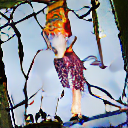

In [ ]:
noise = (1 / 0.18215) * noise
with torch.no_grad():
    image = diffusion_model.vae.decode(noise).sample


image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images][0]
pil_images